**Training** (run locally and configure cpu count based off your device)

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, AutoConfig
from datasets import Dataset
from tqdm.auto import tqdm
from safetensors.torch import load_file
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from huggingface_hub import HfApi, login
import numpy as np








In [ ]:
torch.set_num_threads(8)    #this allows parallelism, adjust based off of your own device 
torch.backends.mkldnn.enabled = True


api_token = "" #put your own huggingface token here :)
login(token=api_token)



/Users/diegoaguirre/Downloads/Finetuning/lol_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
model_name = "distilbert-base-uncased"    #change the model as your see fit
tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=api_token)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, use_auth_token=api_token)


/Users/diegoaguirre/Downloads/Finetuning/lol_env/lib/python3.11/site-packages/transformers/models/auto/tokenization_auto.py:809: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/Users/diegoaguirre/Downloads/Finetuning/lol_env/lib/python3.11/site-packages/transformers/models/auto/auto_factory.py:471: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
data_df = pd.read_csv("/Users/diegoaguirre/Downloads/Finetuning/training.csv")
label_mapping = {"democrat": 0, "republican": 1}
dataset = Dataset.from_dict({
    "text": data_df["description"],
    "label": [label_mapping[label.lower()] for label in data_df["label"]]
})


tokenized_dataset = dataset.map(lambda x: tokenizer(x["text"], truncation=True, padding="max_length", max_length=64), batched=True)


train_test = tokenized_dataset.train_test_split(test_size=0.1)


Map: 100%|██████████| 37461/37461 [00:01<00:00, 21950.06 examples/s]


In [ ]:
output_dir = "./fine_tuned_party_classifier"   #adjust the output directory as needed 
training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    num_train_epochs=3,
    learning_rate=5e-5,
    evaluation_strategy="epoch",
    logging_dir=f"{output_dir}/logs",
    logging_steps=100,
    weight_decay=0.01,
    report_to="none",
    no_cuda=True,
    dataloader_num_workers=4,
    dataloader_drop_last=True
)


/Users/diegoaguirre/Downloads/Finetuning/lol_env/lib/python3.11/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/Users/diegoaguirre/Downloads/Finetuning/lol_env/lib/python3.11/site-packages/transformers/training_args.py:1574: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


In [ ]:
class ProgressCallback(TrainerCallback):
    def on_train_begin(self, args, state, control, **kwargs):
        self.progress_bar = tqdm(total=state.max_steps, desc="Training Progress")

    def on_step_end(self, args, state, control, **kwargs):
        self.progress_bar.update(1)

    def on_train_end(self, args, state, control, **kwargs):
        self.progress_bar.close()


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_test["train"],
    eval_dataset=train_test["test"],
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    callbacks=[ProgressCallback()]
)

trainer.train()   #this will take time, follow the progress bar 


Training Progress:   0%|          | 0/12642 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENI

{'loss': 1.3786, 'grad_norm': 4.6521124839782715, 'learning_rate': 4.960449295997469e-05, 'epoch': 0.02}


                                                                        
Training Progress:   2%|▏         | 200/12642 [04:04<3:59:03,  1.15s/it]

{'loss': 1.3609, 'grad_norm': 5.525229454040527, 'learning_rate': 4.920898591994938e-05, 'epoch': 0.05}


                                                                        
Training Progress:   2%|▏         | 300/12642 [06:07<4:13:34,  1.23s/it]

{'loss': 1.2603, 'grad_norm': 7.906901836395264, 'learning_rate': 4.8813478879924066e-05, 'epoch': 0.07}


                                                                        
Training Progress:   3%|▎         | 400/12642 [08:13<4:10:15,  1.23s/it]

{'loss': 1.2311, 'grad_norm': 5.646717548370361, 'learning_rate': 4.841797183989875e-05, 'epoch': 0.09}


                                                                        
Training Progress:   4%|▍         | 500/12642 [10:18<4:18:09,  1.28s/it]

{'loss': 1.2571, 'grad_norm': 5.919605255126953, 'learning_rate': 4.802246479987344e-05, 'epoch': 0.12}


                                                                        
Training Progress:   5%|▍         | 600/12642 [12:48<4:07:15,  1.23s/it]

{'loss': 1.2732, 'grad_norm': 3.2394726276397705, 'learning_rate': 4.762695775984813e-05, 'epoch': 0.14}


                                                                        
Training Progress:   6%|▌         | 700/12642 [14:57<4:23:36,  1.32s/it]

{'loss': 1.213, 'grad_norm': 12.278338432312012, 'learning_rate': 4.7231450719822815e-05, 'epoch': 0.17}


                                                                        
Training Progress:   6%|▋         | 800/12642 [17:08<4:36:08,  1.40s/it]

{'loss': 1.2021, 'grad_norm': 6.97418212890625, 'learning_rate': 4.68359436797975e-05, 'epoch': 0.19}


                                                                        
Training Progress:   7%|▋         | 900/12642 [19:21<4:09:36,  1.28s/it]

{'loss': 1.1899, 'grad_norm': 5.238426685333252, 'learning_rate': 4.6440436639772186e-05, 'epoch': 0.21}


                                                                         
Training Progress:   8%|▊         | 1000/12642 [21:38<6:51:27,  2.12s/it]

{'loss': 1.19, 'grad_norm': 8.997023582458496, 'learning_rate': 4.604492959974688e-05, 'epoch': 0.24}


                                                                         
Training Progress:   9%|▊         | 1100/12642 [25:20<6:58:48,  2.18s/it]

{'loss': 1.2039, 'grad_norm': 13.985763549804688, 'learning_rate': 4.5649422559721564e-05, 'epoch': 0.26}


                                                                         
Training Progress:   9%|▉         | 1200/12642 [28:55<6:31:23,  2.05s/it]

{'loss': 1.1869, 'grad_norm': 8.703412055969238, 'learning_rate': 4.5253915519696257e-05, 'epoch': 0.28}


                                                                         
Training Progress:  10%|█         | 1300/12642 [31:29<3:24:37,  1.08s/it]

{'loss': 1.2097, 'grad_norm': 5.480921745300293, 'learning_rate': 4.4858408479670935e-05, 'epoch': 0.31}


                                                                         
Training Progress:  11%|█         | 1400/12642 [33:19<3:18:42,  1.06s/it]

{'loss': 1.1207, 'grad_norm': 6.167618751525879, 'learning_rate': 4.446290143964563e-05, 'epoch': 0.33}


                                                                         
Training Progress:  12%|█▏        | 1500/12642 [35:05<3:13:21,  1.04s/it]

{'loss': 1.0896, 'grad_norm': 4.360960960388184, 'learning_rate': 4.406739439962031e-05, 'epoch': 0.36}


                                                                         
Training Progress:  13%|█▎        | 1600/12642 [36:50<3:09:22,  1.03s/it]

{'loss': 1.1424, 'grad_norm': 12.7926607131958, 'learning_rate': 4.3671887359595006e-05, 'epoch': 0.38}


                                                                         
Training Progress:  13%|█▎        | 1700/12642 [38:33<3:13:15,  1.06s/it]

{'loss': 1.1682, 'grad_norm': 5.389777660369873, 'learning_rate': 4.327638031956969e-05, 'epoch': 0.4}


                                                                         
Training Progress:  14%|█▍        | 1800/12642 [40:17<3:06:32,  1.03s/it]

{'loss': 1.1452, 'grad_norm': 10.400866508483887, 'learning_rate': 4.288087327954438e-05, 'epoch': 0.43}


                                                                         
Training Progress:  15%|█▌        | 1900/12642 [42:00<3:18:38,  1.11s/it]

{'loss': 1.0905, 'grad_norm': 9.446220397949219, 'learning_rate': 4.248536623951906e-05, 'epoch': 0.45}


                                                                         
Training Progress:  16%|█▌        | 2000/12642 [43:44<3:05:50,  1.05s/it]

{'loss': 1.0992, 'grad_norm': 20.586811065673828, 'learning_rate': 4.2089859199493755e-05, 'epoch': 0.47}


                                                                         
Training Progress:  17%|█▋        | 2100/12642 [45:32<3:03:51,  1.05s/it]

{'loss': 1.1443, 'grad_norm': 7.797139644622803, 'learning_rate': 4.169435215946844e-05, 'epoch': 0.5}


                                                                         
Training Progress:  17%|█▋        | 2200/12642 [47:18<3:03:08,  1.05s/it]

{'loss': 1.1087, 'grad_norm': 14.45800495147705, 'learning_rate': 4.129884511944313e-05, 'epoch': 0.52}


                                                                         
Training Progress:  18%|█▊        | 2300/12642 [49:17<4:08:30,  1.44s/it]

{'loss': 1.0917, 'grad_norm': 4.590865135192871, 'learning_rate': 4.090333807941781e-05, 'epoch': 0.55}


                                                                         
Training Progress:  19%|█▉        | 2400/12642 [51:39<3:55:51,  1.38s/it]

{'loss': 1.0721, 'grad_norm': 4.566833019256592, 'learning_rate': 4.0507831039392504e-05, 'epoch': 0.57}


                                                                         
Training Progress:  20%|█▉        | 2500/12642 [53:58<3:58:55,  1.41s/it]

{'loss': 1.0813, 'grad_norm': 7.05228853225708, 'learning_rate': 4.011232399936719e-05, 'epoch': 0.59}


                                                                         
Training Progress:  21%|██        | 2600/12642 [56:18<3:53:21,  1.39s/it]

{'loss': 1.1088, 'grad_norm': 10.827848434448242, 'learning_rate': 3.971681695934188e-05, 'epoch': 0.62}


                                                                         
Training Progress:  21%|██▏       | 2700/12642 [58:36<3:48:05,  1.38s/it]

{'loss': 1.0585, 'grad_norm': 5.964132785797119, 'learning_rate': 3.932130991931657e-05, 'epoch': 0.64}


                                                                           
Training Progress:  22%|██▏       | 2800/12642 [1:00:53<3:40:04,  1.34s/it]

{'loss': 1.0568, 'grad_norm': 13.354345321655273, 'learning_rate': 3.892580287929125e-05, 'epoch': 0.66}


                                                                           
Training Progress:  23%|██▎       | 2900/12642 [1:03:09<3:35:20,  1.33s/it]

{'loss': 1.0813, 'grad_norm': 12.774130821228027, 'learning_rate': 3.853029583926594e-05, 'epoch': 0.69}


                                                                           
Training Progress:  24%|██▎       | 3000/12642 [1:05:27<3:48:16,  1.42s/it]

{'loss': 1.0181, 'grad_norm': 4.329397678375244, 'learning_rate': 3.813478879924063e-05, 'epoch': 0.71}


                                                                           
Training Progress:  25%|██▍       | 3100/12642 [1:07:46<3:32:19,  1.34s/it]

{'loss': 1.0535, 'grad_norm': 11.588078498840332, 'learning_rate': 3.773928175921532e-05, 'epoch': 0.74}


                                                                           
Training Progress:  25%|██▌       | 3200/12642 [1:10:01<3:36:10,  1.37s/it]

{'loss': 1.087, 'grad_norm': 5.301726818084717, 'learning_rate': 3.734377471919e-05, 'epoch': 0.76}


                                                                           
Training Progress:  26%|██▌       | 3300/12642 [1:12:19<3:40:45,  1.42s/it]

{'loss': 1.0893, 'grad_norm': 4.925588130950928, 'learning_rate': 3.694826767916469e-05, 'epoch': 0.78}


                                                                           
Training Progress:  27%|██▋       | 3400/12642 [1:14:24<2:34:09,  1.00s/it]

{'loss': 1.0558, 'grad_norm': 7.898720741271973, 'learning_rate': 3.655276063913938e-05, 'epoch': 0.81}


                                                                           
Training Progress:  28%|██▊       | 3500/12642 [1:16:05<2:34:19,  1.01s/it]

{'loss': 1.0654, 'grad_norm': 7.725509166717529, 'learning_rate': 3.6157253599114066e-05, 'epoch': 0.83}


                                                                           
Training Progress:  28%|██▊       | 3600/12642 [1:17:47<2:32:32,  1.01s/it]

{'loss': 1.024, 'grad_norm': 8.421597480773926, 'learning_rate': 3.576174655908875e-05, 'epoch': 0.85}


                                                                           
Training Progress:  29%|██▉       | 3700/12642 [1:19:27<2:29:13,  1.00s/it]

{'loss': 1.06, 'grad_norm': 8.30685043334961, 'learning_rate': 3.5366239519063444e-05, 'epoch': 0.88}


                                                                           
Training Progress:  30%|███       | 3800/12642 [1:21:09<2:28:48,  1.01s/it]

{'loss': 1.0642, 'grad_norm': 18.393131256103516, 'learning_rate': 3.497073247903813e-05, 'epoch': 0.9}


                                                                           
Training Progress:  31%|███       | 3900/12642 [1:22:50<2:31:07,  1.04s/it]

{'loss': 1.0374, 'grad_norm': 6.630168914794922, 'learning_rate': 3.4575225439012815e-05, 'epoch': 0.93}


                                                                           
Training Progress:  32%|███▏      | 4000/12642 [1:24:46<3:12:45,  1.34s/it]

{'loss': 0.9712, 'grad_norm': 93.67436981201172, 'learning_rate': 3.41797183989875e-05, 'epoch': 0.95}


                                                                           
Training Progress:  32%|███▏      | 4100/12642 [1:27:04<3:16:49,  1.38s/it]

{'loss': 1.0238, 'grad_norm': 14.371109008789062, 'learning_rate': 3.378421135896219e-05, 'epoch': 0.97}


                                                                           
Training Progress:  33%|███▎      | 4200/12642 [1:29:22<3:11:32,  1.36s/it]

{'loss': 1.0294, 'grad_norm': 6.357786178588867, 'learning_rate': 3.338870431893688e-05, 'epoch': 1.0}


Training Progress:  33%|███▎      | 4214/12642 [1:30:00<17:07:49,  7.32s/it]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment

{'eval_loss': 0.5501448512077332, 'eval_runtime': 110.3487, 'eval_samples_per_second': 33.956, 'eval_steps_per_second': 4.25, 'epoch': 1.0}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

{'loss': 0.9771, 'grad_norm': 8.835042953491211, 'learning_rate': 3.2993197278911564e-05, 'epoch': 1.02}


                                                                           
Training Progress:  35%|███▍      | 4400/12642 [1:36:21<3:09:10,  1.38s/it]

{'loss': 0.8517, 'grad_norm': 5.064375400543213, 'learning_rate': 3.259769023888625e-05, 'epoch': 1.04}


                                                                           
Training Progress:  36%|███▌      | 4500/12642 [1:38:39<3:09:43,  1.40s/it]

{'loss': 0.8958, 'grad_norm': 5.1682209968566895, 'learning_rate': 3.220218319886094e-05, 'epoch': 1.07}


                                                                           
Training Progress:  36%|███▋      | 4600/12642 [1:40:59<3:03:56,  1.37s/it]

{'loss': 0.8457, 'grad_norm': 16.270915985107422, 'learning_rate': 3.180667615883563e-05, 'epoch': 1.09}


                                                                           
Training Progress:  37%|███▋      | 4700/12642 [1:43:17<3:01:02,  1.37s/it]

{'loss': 0.8658, 'grad_norm': 26.651447296142578, 'learning_rate': 3.141116911881032e-05, 'epoch': 1.12}


                                                                           
Training Progress:  38%|███▊      | 4800/12642 [1:45:35<3:03:25,  1.40s/it]

{'loss': 0.9724, 'grad_norm': 8.036600112915039, 'learning_rate': 3.1015662078785e-05, 'epoch': 1.14}


                                                                           
Training Progress:  39%|███▉      | 4900/12642 [1:47:55<3:00:11,  1.40s/it]

{'loss': 0.8215, 'grad_norm': 56.06874084472656, 'learning_rate': 3.062015503875969e-05, 'epoch': 1.16}


                                                                           
Training Progress:  40%|███▉      | 5000/12642 [1:50:14<2:56:28,  1.39s/it]

{'loss': 0.9083, 'grad_norm': 19.977649688720703, 'learning_rate': 3.022464799873438e-05, 'epoch': 1.19}


                                                                           
Training Progress:  40%|████      | 5100/12642 [1:52:35<2:58:27,  1.42s/it]

{'loss': 0.9219, 'grad_norm': 18.772855758666992, 'learning_rate': 2.982914095870907e-05, 'epoch': 1.21}


                                                                           
Training Progress:  41%|████      | 5200/12642 [1:54:53<2:48:05,  1.36s/it]

{'loss': 0.825, 'grad_norm': 9.790619850158691, 'learning_rate': 2.9433633918683755e-05, 'epoch': 1.23}


                                                                           
Training Progress:  42%|████▏     | 5300/12642 [1:57:11<2:49:08,  1.38s/it]

{'loss': 0.7827, 'grad_norm': 11.288880348205566, 'learning_rate': 2.903812687865844e-05, 'epoch': 1.26}


                                                                           
Training Progress:  43%|████▎     | 5400/12642 [1:59:31<2:46:22,  1.38s/it]

{'loss': 0.8564, 'grad_norm': 6.208596706390381, 'learning_rate': 2.864261983863313e-05, 'epoch': 1.28}


                                                                           
Training Progress:  44%|████▎     | 5500/12642 [2:01:49<2:45:11,  1.39s/it]

{'loss': 0.772, 'grad_norm': 11.693012237548828, 'learning_rate': 2.8247112798607815e-05, 'epoch': 1.31}


                                                                           
Training Progress:  44%|████▍     | 5600/12642 [2:04:10<2:41:15,  1.37s/it]

{'loss': 0.8447, 'grad_norm': 11.534706115722656, 'learning_rate': 2.7851605758582504e-05, 'epoch': 1.33}


                                                                           
Training Progress:  45%|████▌     | 5700/12642 [2:06:27<2:39:08,  1.38s/it]

{'loss': 0.7784, 'grad_norm': 27.29192543029785, 'learning_rate': 2.7456098718557193e-05, 'epoch': 1.35}


                                                                           
Training Progress:  46%|████▌     | 5800/12642 [2:08:46<2:36:56,  1.38s/it]

{'loss': 0.8226, 'grad_norm': 10.118823051452637, 'learning_rate': 2.706059167853188e-05, 'epoch': 1.38}


                                                                           
Training Progress:  47%|████▋     | 5900/12642 [2:11:03<2:33:51,  1.37s/it]

{'loss': 0.8459, 'grad_norm': 8.450340270996094, 'learning_rate': 2.6665084638506564e-05, 'epoch': 1.4}


                                                                           
Training Progress:  47%|████▋     | 6000/12642 [2:13:21<2:36:16,  1.41s/it]

{'loss': 0.7814, 'grad_norm': 10.517066955566406, 'learning_rate': 2.6269577598481253e-05, 'epoch': 1.42}


                                                                           
Training Progress:  48%|████▊     | 6100/12642 [2:15:43<2:32:11,  1.40s/it]

{'loss': 0.8392, 'grad_norm': 19.479333877563477, 'learning_rate': 2.5874070558455942e-05, 'epoch': 1.45}


                                                                           
Training Progress:  49%|████▉     | 6200/12642 [2:18:01<2:28:05,  1.38s/it]

{'loss': 0.8609, 'grad_norm': 11.751665115356445, 'learning_rate': 2.547856351843063e-05, 'epoch': 1.47}


                                                                           
Training Progress:  50%|████▉     | 6300/12642 [2:20:18<2:25:55,  1.38s/it]

{'loss': 0.7404, 'grad_norm': 13.44604206085205, 'learning_rate': 2.5083056478405313e-05, 'epoch': 1.5}


                                                                           
Training Progress:  51%|█████     | 6400/12642 [2:22:39<2:24:22,  1.39s/it]

{'loss': 0.8015, 'grad_norm': 14.044739723205566, 'learning_rate': 2.4687549438380002e-05, 'epoch': 1.52}


                                                                           
Training Progress:  51%|█████▏    | 6500/12642 [2:24:56<2:18:04,  1.35s/it]

{'loss': 0.9102, 'grad_norm': 3.8418314456939697, 'learning_rate': 2.429204239835469e-05, 'epoch': 1.54}


                                                                           
Training Progress:  52%|█████▏    | 6600/12642 [2:27:16<2:23:44,  1.43s/it]

{'loss': 0.8509, 'grad_norm': 9.006734848022461, 'learning_rate': 2.389653535832938e-05, 'epoch': 1.57}


                                                                           
Training Progress:  53%|█████▎    | 6700/12642 [2:29:34<2:12:11,  1.33s/it]

{'loss': 0.8476, 'grad_norm': 9.466697692871094, 'learning_rate': 2.3501028318304066e-05, 'epoch': 1.59}


                                                                           
Training Progress:  54%|█████▍    | 6800/12642 [2:31:52<2:14:21,  1.38s/it]

{'loss': 0.7492, 'grad_norm': 3.406245231628418, 'learning_rate': 2.3105521278278755e-05, 'epoch': 1.61}


                                                                           
Training Progress:  55%|█████▍    | 6900/12642 [2:34:11<2:12:58,  1.39s/it]

{'loss': 0.9042, 'grad_norm': 14.634008407592773, 'learning_rate': 2.271001423825344e-05, 'epoch': 1.64}


                                                                           
Training Progress:  55%|█████▌    | 7000/12642 [2:36:28<2:08:11,  1.36s/it]

{'loss': 0.8896, 'grad_norm': 5.051882266998291, 'learning_rate': 2.231450719822813e-05, 'epoch': 1.66}


                                                                           
Training Progress:  56%|█████▌    | 7100/12642 [2:38:47<2:08:56,  1.40s/it]

{'loss': 0.7618, 'grad_norm': 39.23543167114258, 'learning_rate': 2.1919000158202818e-05, 'epoch': 1.68}


                                                                           
Training Progress:  57%|█████▋    | 7200/12642 [2:41:06<2:02:13,  1.35s/it]

{'loss': 0.8769, 'grad_norm': 6.859786033630371, 'learning_rate': 2.1523493118177504e-05, 'epoch': 1.71}


                                                                           
Training Progress:  58%|█████▊    | 7300/12642 [2:43:22<2:01:43,  1.37s/it]

{'loss': 0.8288, 'grad_norm': 20.802783966064453, 'learning_rate': 2.1127986078152193e-05, 'epoch': 1.73}


                                                                           
Training Progress:  59%|█████▊    | 7400/12642 [2:45:39<1:58:13,  1.35s/it]

{'loss': 0.8472, 'grad_norm': 51.861083984375, 'learning_rate': 2.073247903812688e-05, 'epoch': 1.76}


                                                                           
Training Progress:  59%|█████▉    | 7500/12642 [2:47:55<1:57:30,  1.37s/it]

{'loss': 0.9093, 'grad_norm': 10.434285163879395, 'learning_rate': 2.0336971998101567e-05, 'epoch': 1.78}


                                                                           
Training Progress:  60%|██████    | 7600/12642 [2:50:12<1:53:06,  1.35s/it]

{'loss': 0.8004, 'grad_norm': 10.100522994995117, 'learning_rate': 1.9941464958076256e-05, 'epoch': 1.8}


                                                                           
Training Progress:  61%|██████    | 7700/12642 [2:52:30<1:53:10,  1.37s/it]

{'loss': 0.7086, 'grad_norm': 18.161466598510742, 'learning_rate': 1.9545957918050942e-05, 'epoch': 1.83}


                                                                           
Training Progress:  62%|██████▏   | 7800/12642 [2:54:45<1:46:48,  1.32s/it]

{'loss': 0.9087, 'grad_norm': 5.820308685302734, 'learning_rate': 1.915045087802563e-05, 'epoch': 1.85}


                                                                           
Training Progress:  62%|██████▏   | 7900/12642 [2:57:03<1:47:10,  1.36s/it]

{'loss': 0.7507, 'grad_norm': 7.8856706619262695, 'learning_rate': 1.8754943838000317e-05, 'epoch': 1.87}


                                                                           
Training Progress:  63%|██████▎   | 8000/12642 [2:59:19<1:44:50,  1.36s/it]

{'loss': 0.8393, 'grad_norm': 8.004161834716797, 'learning_rate': 1.8359436797975006e-05, 'epoch': 1.9}


                                                                           
Training Progress:  64%|██████▍   | 8100/12642 [3:01:37<1:41:15,  1.34s/it]

{'loss': 0.8166, 'grad_norm': 7.326176166534424, 'learning_rate': 1.7963929757949695e-05, 'epoch': 1.92}


                                                                           
Training Progress:  65%|██████▍   | 8200/12642 [3:03:55<1:42:28,  1.38s/it]

{'loss': 0.788, 'grad_norm': 21.36452865600586, 'learning_rate': 1.756842271792438e-05, 'epoch': 1.95}


                                                                           
Training Progress:  66%|██████▌   | 8300/12642 [3:06:12<1:38:13,  1.36s/it]

{'loss': 0.7264, 'grad_norm': 6.711030006408691, 'learning_rate': 1.717291567789907e-05, 'epoch': 1.97}


                                                                           
Training Progress:  66%|██████▋   | 8400/12642 [3:08:28<1:35:20,  1.35s/it]

{'loss': 0.8567, 'grad_norm': 3.7796061038970947, 'learning_rate': 1.6777408637873755e-05, 'epoch': 1.99}


Training Progress:  67%|██████▋   | 8428/12642 [3:09:26<8:38:53,  7.39s/it]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment 

{'eval_loss': 0.5395067930221558, 'eval_runtime': 112.2135, 'eval_samples_per_second': 33.392, 'eval_steps_per_second': 4.18, 'epoch': 2.0}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

{'loss': 0.6023, 'grad_norm': 52.41786193847656, 'learning_rate': 1.6381901597848444e-05, 'epoch': 2.02}


                                                                           
Training Progress:  68%|██████▊   | 8600/12642 [3:15:33<1:35:29,  1.42s/it]

{'loss': 0.5703, 'grad_norm': 73.1381607055664, 'learning_rate': 1.5986394557823133e-05, 'epoch': 2.04}


                                                                           
Training Progress:  69%|██████▉   | 8700/12642 [3:17:53<1:37:21,  1.48s/it]

{'loss': 0.6755, 'grad_norm': 20.750038146972656, 'learning_rate': 1.5590887517797818e-05, 'epoch': 2.06}


                                                                           
Training Progress:  70%|██████▉   | 8800/12642 [3:20:11<1:25:42,  1.34s/it]

{'loss': 0.6888, 'grad_norm': 91.78672790527344, 'learning_rate': 1.5195380477772506e-05, 'epoch': 2.09}


                                                                           
Training Progress:  70%|███████   | 8900/12642 [3:22:28<1:26:36,  1.39s/it]

{'loss': 0.7217, 'grad_norm': 1.4049581289291382, 'learning_rate': 1.4799873437747191e-05, 'epoch': 2.11}


                                                                           
Training Progress:  71%|███████   | 9000/12642 [3:24:44<1:20:48,  1.33s/it]

{'loss': 0.5942, 'grad_norm': 45.430198669433594, 'learning_rate': 1.440436639772188e-05, 'epoch': 2.14}


                                                                           
Training Progress:  72%|███████▏  | 9100/12642 [3:27:03<1:20:51,  1.37s/it]

{'loss': 0.6391, 'grad_norm': 125.4113540649414, 'learning_rate': 1.4008859357696569e-05, 'epoch': 2.16}


                                                                           
Training Progress:  73%|███████▎  | 9200/12642 [3:29:21<1:19:45,  1.39s/it]

{'loss': 0.5241, 'grad_norm': 3.148965835571289, 'learning_rate': 1.3613352317671255e-05, 'epoch': 2.18}


                                                                           
Training Progress:  74%|███████▎  | 9300/12642 [3:31:37<1:14:45,  1.34s/it]

{'loss': 0.6131, 'grad_norm': 23.341684341430664, 'learning_rate': 1.3217845277645944e-05, 'epoch': 2.21}


                                                                           
Training Progress:  74%|███████▍  | 9400/12642 [3:33:56<1:15:07,  1.39s/it]

{'loss': 0.6282, 'grad_norm': 12.142239570617676, 'learning_rate': 1.282233823762063e-05, 'epoch': 2.23}


                                                                           
Training Progress:  75%|███████▌  | 9500/12642 [3:36:13<1:10:09,  1.34s/it]

{'loss': 0.6239, 'grad_norm': 50.47338104248047, 'learning_rate': 1.2426831197595318e-05, 'epoch': 2.25}


                                                                           
Training Progress:  76%|███████▌  | 9600/12642 [3:38:31<1:09:46,  1.38s/it]

{'loss': 0.6684, 'grad_norm': 30.227874755859375, 'learning_rate': 1.2031324157570005e-05, 'epoch': 2.28}


                                                                           
Training Progress:  77%|███████▋  | 9700/12642 [3:40:49<1:06:30,  1.36s/it]

{'loss': 0.5939, 'grad_norm': 48.51819610595703, 'learning_rate': 1.1635817117544693e-05, 'epoch': 2.3}


                                                                           
Training Progress:  78%|███████▊  | 9800/12642 [3:43:06<1:04:28,  1.36s/it]

{'loss': 0.6264, 'grad_norm': 0.3946428894996643, 'learning_rate': 1.1240310077519382e-05, 'epoch': 2.33}


                                                                           
Training Progress:  78%|███████▊  | 9900/12642 [3:45:23<1:02:57,  1.38s/it]

{'loss': 0.6073, 'grad_norm': 51.93174743652344, 'learning_rate': 1.0844803037494067e-05, 'epoch': 2.35}


                                                                            
Training Progress:  79%|███████▉  | 10000/12642 [3:47:41<1:00:19,  1.37s/it]

{'loss': 0.7051, 'grad_norm': 65.0205307006836, 'learning_rate': 1.0449295997468755e-05, 'epoch': 2.37}


                                                                            
Training Progress:  80%|███████▉  | 10100/12642 [3:50:01<1:00:29,  1.43s/it]

{'loss': 0.7586, 'grad_norm': 61.481082916259766, 'learning_rate': 1.0053788957443442e-05, 'epoch': 2.4}


                                                                            
Training Progress:  81%|████████  | 10200/12642 [3:52:20<56:45,  1.39s/it]

{'loss': 0.5047, 'grad_norm': 1.6393446922302246, 'learning_rate': 9.65828191741813e-06, 'epoch': 2.42}


                                                                          
Training Progress:  81%|████████▏ | 10300/12642 [3:54:38<53:06,  1.36s/it]

{'loss': 0.5583, 'grad_norm': 0.5315366387367249, 'learning_rate': 9.262774877392818e-06, 'epoch': 2.44}


                                                                          
Training Progress:  82%|████████▏ | 10400/12642 [3:56:54<51:36,  1.38s/it]

{'loss': 0.6866, 'grad_norm': 12.954483985900879, 'learning_rate': 8.867267837367505e-06, 'epoch': 2.47}


                                                                          
Training Progress:  83%|████████▎ | 10500/12642 [3:59:11<47:27,  1.33s/it]

{'loss': 0.7196, 'grad_norm': 55.47209548950195, 'learning_rate': 8.471760797342193e-06, 'epoch': 2.49}


                                                                            
Training Progress:  84%|████████▍ | 10600/12642 [4:01:29<46:27,  1.37s/it]

{'loss': 0.6061, 'grad_norm': 26.655731201171875, 'learning_rate': 8.07625375731688e-06, 'epoch': 2.52}


                                                                          
Training Progress:  85%|████████▍ | 10700/12642 [4:03:47<45:13,  1.40s/it]

{'loss': 0.5426, 'grad_norm': 0.70160311460495, 'learning_rate': 7.680746717291567e-06, 'epoch': 2.54}


                                                                          
Training Progress:  85%|████████▌ | 10800/12642 [4:06:04<41:31,  1.35s/it]

{'loss': 0.5937, 'grad_norm': 63.8628044128418, 'learning_rate': 7.285239677266256e-06, 'epoch': 2.56}


                                                                          
Training Progress:  86%|████████▌ | 10900/12642 [4:08:21<39:29,  1.36s/it]

{'loss': 0.5888, 'grad_norm': 16.52248764038086, 'learning_rate': 6.889732637240944e-06, 'epoch': 2.59}


                                                                          
Training Progress:  87%|████████▋ | 11000/12642 [4:10:39<38:02,  1.39s/it]

{'loss': 0.6604, 'grad_norm': 45.83100509643555, 'learning_rate': 6.494225597215631e-06, 'epoch': 2.61}


                                                                          
Training Progress:  88%|████████▊ | 11100/12642 [4:12:58<34:55,  1.36s/it]

{'loss': 0.6493, 'grad_norm': 24.243755340576172, 'learning_rate': 6.098718557190318e-06, 'epoch': 2.63}


                                                                          
Training Progress:  89%|████████▊ | 11200/12642 [4:15:15<32:56,  1.37s/it]

{'loss': 0.7044, 'grad_norm': 8.15653133392334, 'learning_rate': 5.703211517165006e-06, 'epoch': 2.66}


                                                                          
Training Progress:  89%|████████▉ | 11300/12642 [4:17:34<30:43,  1.37s/it]

{'loss': 0.5605, 'grad_norm': 16.275358200073242, 'learning_rate': 5.307704477139694e-06, 'epoch': 2.68}


                                                                          
Training Progress:  90%|█████████ | 11400/12642 [4:19:50<27:53,  1.35s/it]

{'loss': 0.6268, 'grad_norm': 1.3432718515396118, 'learning_rate': 4.912197437114381e-06, 'epoch': 2.71}


                                                                          
Training Progress:  91%|█████████ | 11500/12642 [4:22:05<25:51,  1.36s/it]

{'loss': 0.664, 'grad_norm': 0.4580466151237488, 'learning_rate': 4.516690397089068e-06, 'epoch': 2.73}


                                                                          
Training Progress:  92%|█████████▏| 11600/12642 [4:24:20<23:12,  1.34s/it]

{'loss': 0.6309, 'grad_norm': 79.29723358154297, 'learning_rate': 4.1211833570637554e-06, 'epoch': 2.75}


                                                                          
Training Progress:  93%|█████████▎| 11700/12642 [4:26:32<21:02,  1.34s/it]

{'loss': 0.6481, 'grad_norm': 0.38097140192985535, 'learning_rate': 3.7256763170384436e-06, 'epoch': 2.78}


                                                                          
Training Progress:  93%|█████████▎| 11800/12642 [4:28:47<18:27,  1.32s/it]

{'loss': 0.6043, 'grad_norm': 18.118349075317383, 'learning_rate': 3.330169277013131e-06, 'epoch': 2.8}


                                                                          
Training Progress:  94%|█████████▍| 11900/12642 [4:31:00<16:26,  1.33s/it]

{'loss': 0.6291, 'grad_norm': 2.7533459663391113, 'learning_rate': 2.9346622369878186e-06, 'epoch': 2.82}


                                                                          
Training Progress:  95%|█████████▍| 12000/12642 [4:33:15<14:23,  1.34s/it]

{'loss': 0.5986, 'grad_norm': 22.111156463623047, 'learning_rate': 2.539155196962506e-06, 'epoch': 2.85}


                                                                          
Training Progress:  96%|█████████▌| 12100/12642 [4:35:30<11:49,  1.31s/it]

{'loss': 0.5929, 'grad_norm': 37.88743209838867, 'learning_rate': 2.1436481569371936e-06, 'epoch': 2.87}


                                                                          
Training Progress:  97%|█████████▋| 12200/12642 [4:37:43<09:51,  1.34s/it]

{'loss': 0.6544, 'grad_norm': 14.070741653442383, 'learning_rate': 1.7481411169118813e-06, 'epoch': 2.9}


                                                                          
Training Progress:  97%|█████████▋| 12300/12642 [4:39:57<07:46,  1.36s/it]

{'loss': 0.6735, 'grad_norm': 2.324937343597412, 'learning_rate': 1.3526340768865688e-06, 'epoch': 2.92}


                                                                          
Training Progress:  98%|█████████▊| 12400/12642 [4:42:12<05:22,  1.33s/it]

{'loss': 0.6533, 'grad_norm': 4.182478427886963, 'learning_rate': 9.571270368612563e-07, 'epoch': 2.94}


                                                                          
Training Progress:  99%|█████████▉| 12500/12642 [4:44:28<03:12,  1.35s/it]

{'loss': 0.4742, 'grad_norm': 0.4557962417602539, 'learning_rate': 5.616199968359437e-07, 'epoch': 2.97}


                                                                          
Training Progress: 100%|█████████▉| 12600/12642 [4:46:47<00:57,  1.37s/it]

{'loss': 0.6323, 'grad_norm': 27.09185791015625, 'learning_rate': 1.6611295681063123e-07, 'epoch': 2.99}


Training Progress: 100%|██████████| 12642/12642 [4:48:05<00:00,  7.40s/it]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment v

{'eval_loss': 0.9012758731842041, 'eval_runtime': 112.8406, 'eval_samples_per_second': 33.206, 'eval_steps_per_second': 4.156, 'epoch': 3.0}
{'train_runtime': 17400.7613, 'train_samples_per_second': 5.813, 'train_steps_per_second': 0.727, 'train_loss': 0.8631315994745492, 'epoch': 3.0}


TrainOutput(global_step=12642, training_loss=0.8631315994745492, metrics={'train_runtime': 17400.7613, 'train_samples_per_second': 5.813, 'train_steps_per_second': 0.727, 'total_flos': 1674652853809152.0, 'train_loss': 0.8631315994745492, 'epoch': 3.0})

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

config = AutoConfig.from_pretrained("/config.json")

model = AutoModelForSequenceClassification.from_config(config)   #load the finetuned model 

model_weights = load_file("/model.safetensors")
model.load_state_dict(model_weights, strict=False)


<All keys matched successfully>

In [ ]:
def classify_statement(statement):

    inputs = tokenizer(statement, return_tensors="pt", truncation=True, padding=True)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=-1).item()

    label_map = {0: "Democrat", 1: "Republican"}
    return label_map[predicted_class]


# sanity check / example usage 

test_statements = [
    "We need to lower taxes and reduce government spending.",
    "Climate change is one of the biggest threats to our planet.",
    "We should invest more in renewable energy sources.",
]

for statement in test_statements:
    result = classify_statement(statement)
    print(f"Statement: \"{statement}\"\nPredicted Class: {result}\n")


Statement: "We need to lower taxes and reduce government spending."
Predicted Class: Republican

Statement: "Climate change is one of the biggest threats to our planet."
Predicted Class: Democrat

Statement: "We should invest more in renewable energy sources."
Predicted Class: Democrat



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fine-Tuned ROC AUC Score: 0.6043371522094927
Non-Finetuned ROC AUC Score: 0.4333060556464812


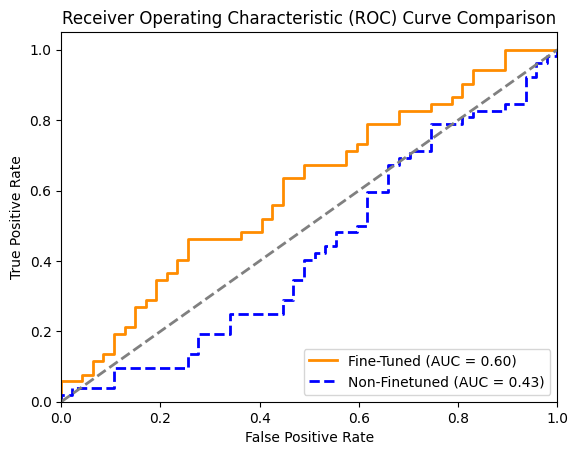

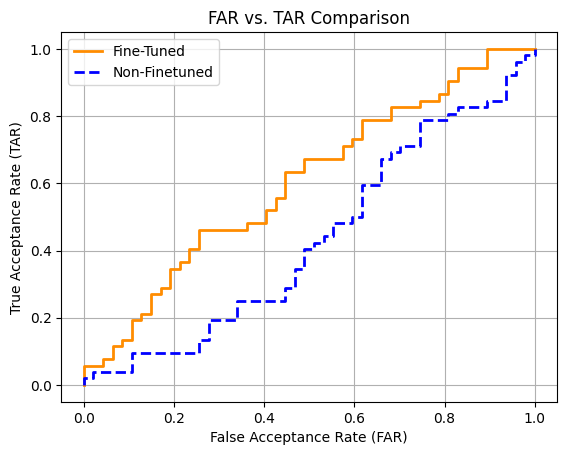

In [ ]:
test_df = pd.read_csv("/Fine Tuning Test Data - Sheet1 (1).csv")    #adjust to your own repo 

label_map = {"Republican": 1, "Democrat": 0}
test_df["Party_encoded"] = test_df["Party"].map(label_map)

test_texts = test_df["Speech"].tolist()
test_labels = test_df["Party_encoded"].tolist()

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

fine_tuned_model = model

non_finetuned_model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased")

def get_predictions(model, texts):
    model.eval()
    predictions = []

    with torch.no_grad():
        for text in texts:
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
            outputs = model(**inputs)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=-1)
            predictions.append(probs[0][1].item())

    return predictions

fine_tuned_preds = get_predictions(fine_tuned_model, test_texts)
non_finetuned_preds = get_predictions(non_finetuned_model, test_texts)

fine_tuned_roc_auc = roc_auc_score(test_labels, fine_tuned_preds)
non_finetuned_roc_auc = roc_auc_score(test_labels, non_finetuned_preds)

print(f"Fine-Tuned ROC AUC Score: {fine_tuned_roc_auc}")
print(f"Non-Finetuned ROC AUC Score: {non_finetuned_roc_auc}")

fpr_fine_tuned, tpr_fine_tuned, _ = roc_curve(test_labels, fine_tuned_preds)
fpr_non_finetuned, tpr_non_finetuned, _ = roc_curve(test_labels, non_finetuned_preds)

plt.figure()
plt.plot(fpr_fine_tuned, tpr_fine_tuned, color="darkorange", lw=2, label=f"Fine-Tuned (AUC = {fine_tuned_roc_auc:.2f})")
plt.plot(fpr_non_finetuned, tpr_non_finetuned, color="blue", lw=2, linestyle="--", label=f"Non-Finetuned (AUC = {non_finetuned_roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve Comparison")
plt.legend(loc="lower right")
plt.show()

plt.figure()
plt.plot(fpr_fine_tuned, tpr_fine_tuned, color="darkorange", lw=2, label="Fine-Tuned")
plt.plot(fpr_non_finetuned, tpr_non_finetuned, color="blue", lw=2, linestyle="--", label="Non-Finetuned")
plt.xlabel("False Acceptance Rate (FAR)")
plt.ylabel("True Acceptance Rate (TAR)")
plt.title("FAR vs. TAR Comparison")
plt.legend()
plt.grid(True)
plt.show()




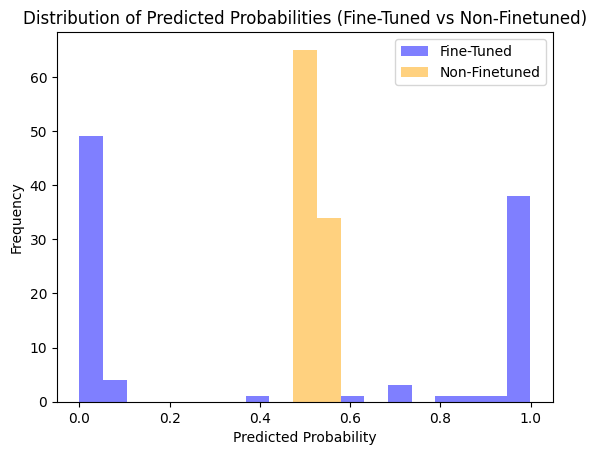

In [ ]:
min_value = min(min(fine_tuned_preds), min(non_finetuned_preds))
max_value = max(max(fine_tuned_preds), max(non_finetuned_preds))

num_bins = 20
bins = np.linspace(min_value, max_value, num_bins)

plt.hist(fine_tuned_preds, bins=bins, color="blue", alpha=0.5, label="Fine-Tuned")
plt.hist(non_finetuned_preds, bins=bins, color="orange", alpha=0.5, label="Non-Finetuned")

plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Probabilities (Fine-Tuned vs Non-Finetuned)")
plt.legend(loc="upper right")

plt.show()
